In [1]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
def get_match_label(match):
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id'] 
    if home_goals > away_goals:
        label.loc[0,'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0,'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0,'label'] = "Defeat"
    return label.loc[0]

In [3]:
def get_fifa_stats(match, player_stats):
    '''Collect fifa stats for a given match'''    
    match_id =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    player_stats_latest = pd.DataFrame()
    names = []
    #Iterate across all players
    for player in players:   
        player_id = match[player]
        #Fetching player stats for given player_id
        stats = player_stats[player_stats.player_api_id == player_id]
        #latest player stats      
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])
        name = "{}_overall_rating".format(player)
        names.append(name)            
        player_stats_latest = pd.concat([player_stats_latest, overall_rating], axis = 1)
    player_stats_latest.columns = names        
    player_stats_latest['match_api_id'] = match_id
    player_stats_latest.reset_index(inplace = True, drop = True)    
    return player_stats_latest.iloc[0]  

In [4]:
def get_fifa_data(matches, player_stats):
    '''Collect fifa data for all matches'''   
    print("Fetching fifa data for each match...")       
    start = time()
    fifa_data = matches.apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
    end = time()    
    print("Fifa data collected in {:.1f} minutes".format((end - start)/60))    
    return fifa_data

In [5]:
def create_features(matches_data, fifa_data, horizontal = True, x = 10):
    ''' Create and aggregate features and labels for all matches. '''
    #Get fifa stats features
    cols = fifa_data.loc[:,(fifa_data.columns.str.contains('date_stat'))]
    fifa_stats_features = fifa_data.drop(cols.columns, axis = 1)
    
    print("Generating match features...")
    start = time()
    #Form match features for all matches
    match_stats_features = matches_data.apply(lambda x: get_match_features(x, matches_data, x = 10), axis = 1)
    match_stats_features.drop(['league_id'], inplace = True, axis = 1)
    end = time()    
    print("Match features generated in {:.1f} minutes".format((end - start)/60))
    
    print("Generating match labels...")
    start = time()    
    labels = matches_data.apply(get_match_label, axis = 1)
    end = time()
    print("Match labels generated in {:.1f} minutes".format((end - start)/60))
    
    #Merging features and labels into one frame
    f = pd.merge(match_stats_features, fifa_stats_features, on = 'match_api_id', how = 'left')
    features = pd.merge(f, labels, on = 'match_api_id', how = 'left')
    features.dropna(inplace = True)
    return features

In [6]:
def get_wins(matches, team):
    ''' Returns the number of wins of a specfic team from a set of matches. '''    
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())
    total_wins = home_wins + away_wins
    return total_wins

In [7]:
def get_goals_conceded(matches, team):
    ''' Fetch the goals conceded of a specfic team from a set of matches. '''
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())
    total_goals = home_goals + away_goals
    return total_goals

In [8]:
def get_goals(matches, team):
    ''' Fetch the goals of a given team from a set of matches. '''    
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())
    total_goals = home_goals + away_goals    
    return total_goals

In [9]:
def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    ''' Fetch the last x matches of two given teams. '''    
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
    return last_matches

In [10]:
def get_last_matches(matches, date, team, x = 10):
    ''' Fetch the last x matches of a given team. '''    
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]                           
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]    
    return last_matches

In [11]:
def get_match_features(match, matches, x = 10):
    ''' Creating match specific features for a given match'''
    ''' Referred https://www.kaggle.com/airback/match-outcome-prediction-in-football.'''
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    #Fetch last 10 matches of home and away team
    matches_home_team = get_last_matches(matches, date, home_team, x = 10)
    matches_away_team = get_last_matches(matches, date, away_team, x = 10)
    #Fetch last 3 matches of both teams against each other
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    #Creating goal variables
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceded = get_goals_conceded(matches_home_team, home_team)
    away_goals_conceded = get_goals_conceded(matches_away_team, away_team)
    
    result = pd.DataFrame()    
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id
    #Creating match features
    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceded
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceded
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team) 
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)    
    return result.loc[0]

In [12]:
path = "/Users/praveen/255/dev"
database = 'database.sqlite'
conn = sqlite3.connect(database)
#Reading required database tables
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data.dropna(subset = rows, inplace = True)
#match_data = match_data.tail(5)
print(match_data.shape)

(21374, 115)


In [13]:
#Fetching FIFA data
fifa_data = get_fifa_data(match_data, player_stats_data)
print(fifa_data.shape)

Fetching fifa data for each match...
Fifa data collected in 18.2 minutes
(21374, 23)


In [14]:
## Generate features
features = create_features(match_data, fifa_data)
print(features.shape)

Generating match features...
Match features generated in 7.1 minutes
Generating match labels...
Match labels generated in 0.8 minutes
(21374, 30)


In [15]:
inputs = features.drop('match_api_id', axis = 1)
print(inputs.shape)

(21374, 29)


In [16]:
inputs.to_csv('fifa_features_final4.csv')

In [17]:
#Exploring the data and creating visualizations
labels = inputs.loc[:,'label']
print(labels.head)

<bound method NDFrame.head of 0           Win
1        Defeat
2           Win
3           Win
4          Draw
          ...  
21369      Draw
21370       Win
21371    Defeat
21372       Win
21373       Win
Name: label, Length: 21374, dtype: object>


In [18]:
features = inputs.drop('label', axis = 1)

In [19]:
features.head(5)


,home_team_goals_difference,away_team_goals_difference,games_won_home_team,games_won_away_team,games_against_won,games_against_lost,home_player_1_overall_rating,home_player_2_overall_rating,home_player_3_overall_rating,home_player_4_overall_rating,...,away_player_2_overall_rating,away_player_3_overall_rating,away_player_4_overall_rating,away_player_5_overall_rating,away_player_6_overall_rating,away_player_7_overall_rating,away_player_8_overall_rating,away_player_9_overall_rating,away_player_10_overall_rating,away_player_11_overall_rating
0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,57.0,67.0,53.0,...,70.0,59.0,55.0,54.0,72.0,67.0,65.0,70.0,68.0,63.0
1,0.0,0.0,0.0,0.0,0.0,0.0,64.0,64.0,63.0,62.0,...,67.0,66.0,67.0,66.0,70.0,69.0,68.0,67.0,73.0,68.0
2,0.0,0.0,0.0,0.0,0.0,0.0,67.0,72.0,69.0,69.0,...,66.0,61.0,60.0,49.0,64.0,67.0,66.0,55.0,58.0,64.0
3,1.0,2.0,1.0,1.0,0.0,0.0,58.0,57.0,67.0,65.0,...,72.0,72.0,66.0,67.0,75.0,70.0,74.0,74.0,70.0,69.0
4,-2.0,0.0,0.0,0.0,0.0,0.0,61.0,66.0,61.0,61.0,...,62.0,57.0,57.0,51.0,58.0,66.0,57.0,60.0,63.0,65.0


In [20]:
from pandas_profiling import ProfileReport
profile = ProfileReport(features, title="Pandas Profiling Report")
profile.to_file("Analysis_prav1.html")

<AxesSubplot:>

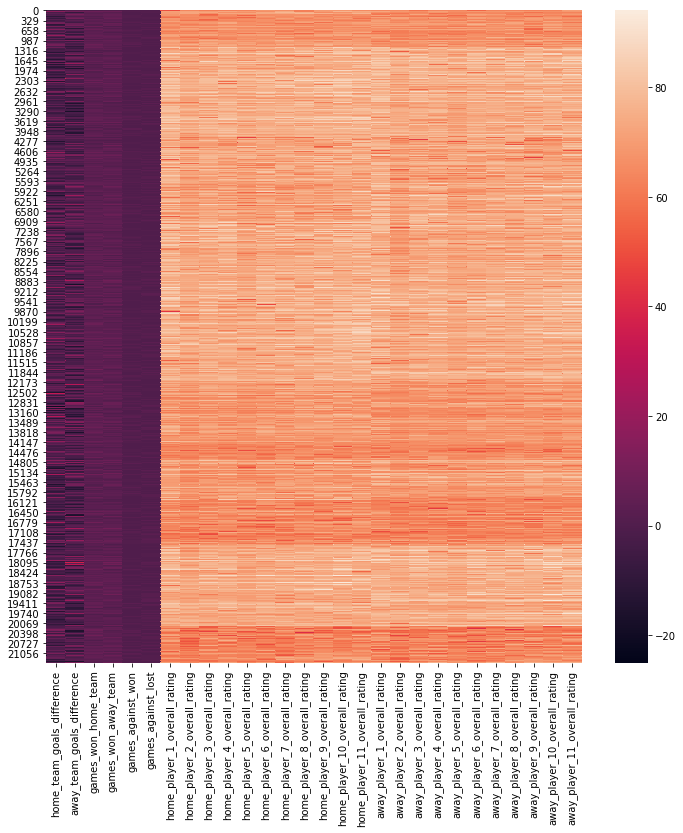

In [21]:
plt.figure(figsize=(12,12))
sns.heatmap(features)

In [22]:
#Splitting the data into Train and Test data sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 42, 
                                                                        stratify = labels)

In [23]:
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')

In [24]:
RF_clf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=1)

In [25]:
RFPred = RF_clf.predict(X_test)

In [26]:
print(classification_report(y_test, RFPred))

              precision    recall  f1-score   support

      Defeat       0.49      0.44      0.46      1542
        Draw       0.31      0.03      0.06      1349
         Win       0.53      0.83      0.65      2453

    accuracy                           0.52      5344
   macro avg       0.44      0.43      0.39      5344
weighted avg       0.46      0.52      0.45      5344



In [27]:
AB_clf = AdaBoostClassifier(n_estimators = 200, random_state = 2)

In [28]:
AB_clf.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=200, random_state=2)

In [29]:
ABPred = AB_clf.predict(X_test)

In [30]:
print(classification_report(y_test, ABPred))

              precision    recall  f1-score   support

      Defeat       0.47      0.48      0.48      1542
        Draw       0.24      0.02      0.03      1349
         Win       0.54      0.81      0.65      2453

    accuracy                           0.52      5344
   macro avg       0.42      0.44      0.39      5344
weighted avg       0.45      0.52      0.44      5344



In [31]:
GNB_clf = GaussianNB()

In [32]:
GNB_clf.fit(X_train,y_train)

GaussianNB()

In [33]:
GNBPred = GNB_clf.predict(X_test)

In [34]:
print(classification_report(y_test, GNBPred))

              precision    recall  f1-score   support

      Defeat       0.44      0.58      0.50      1542
        Draw       0.28      0.17      0.22      1349
         Win       0.60      0.61      0.61      2453

    accuracy                           0.49      5344
   macro avg       0.44      0.46      0.44      5344
weighted avg       0.48      0.49      0.48      5344



In [35]:
KNN_clf =  KNeighborsClassifier()

In [36]:
KNN_clf.fit(X_train,y_train)

KNeighborsClassifier()

In [37]:
knnPred = KNN_clf.predict(X_test)

In [38]:
print(classification_report(y_test, knnPred))

              precision    recall  f1-score   support

      Defeat       0.41      0.50      0.45      1542
        Draw       0.27      0.23      0.25      1349
         Win       0.57      0.53      0.55      2453

    accuracy                           0.45      5344
   macro avg       0.41      0.42      0.41      5344
weighted avg       0.45      0.45      0.44      5344



In [39]:
LOG_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced')

In [40]:
LOG_clf.fit(X_train,y_train)

/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(class_weight='balanced', multi_class='ovr', solver='sag')

In [41]:
logPred = LOG_clf.predict(X_test)

In [42]:
print(classification_report(y_test, logPred))

              precision    recall  f1-score   support

      Defeat       0.44      0.62      0.51      1542
        Draw       0.30      0.16      0.21      1349
         Win       0.61      0.61      0.61      2453

    accuracy                           0.50      5344
   macro avg       0.45      0.46      0.44      5344
weighted avg       0.48      0.50      0.48      5344

